## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.tree import plot_tree

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

In [2]:
#%load_ext pycodestyle_magic
#%pycodestyle_on

## Read the data

In [3]:
churn_data = pd.read_csv('DATA_Customer-Churn.csv')
print(churn_data.shape)
churn_data.head()

(7043, 16)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


## Short exploration

In [4]:
# Make all column names lowercase
churn_data.columns = [col.lower() for col in churn_data.columns]

In [5]:
# Check for missing values and data types
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   onlinesecurity    7043 non-null   object 
 7   onlinebackup      7043 non-null   object 
 8   deviceprotection  7043 non-null   object 
 9   techsupport       7043 non-null   object 
 10  streamingtv       7043 non-null   object 
 11  streamingmovies   7043 non-null   object 
 12  contract          7043 non-null   object 
 13  monthlycharges    7043 non-null   float64
 14  totalcharges      7043 non-null   object 
 15  churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

It seems like there are no missing values. However, when we try to convert the type in `TotalCharges`, we get a `ValueError`

```python
pd.to_numeric(churn_data['totalcharges'])
```
```
> ValueError: Unable to parse string " " 
```

Apparently some values are just a single space character `" "` (which probably represents missing data). Let's deal with them:

In [6]:
churn_data['totalcharges'] = pd.to_numeric(churn_data['totalcharges'], errors='coerce')  # invalid parsing will be set as NaN
churn_data['totalcharges'].fillna(
    churn_data['totalcharges'].mean(),
    inplace=True)  # replace NaN by the mean

In [7]:
# Check if the changes took place
print('churn_data[\'totalcharges\']\nDtype: {}\nMissing values: {}'.format(
    churn_data['totalcharges'].dtype,
    churn_data['totalcharges'].isna().sum())
     )

churn_data['totalcharges']
Dtype: float64
Missing values: 0


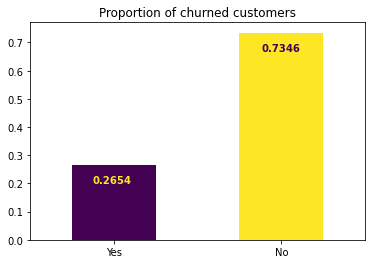

In [8]:
# Check the target variable
cmap = plt.cm.get_cmap('viridis', 2).colors
churn_data['churn'].value_counts(normalize=True, sort=True, ascending=True).plot.bar(rot=0, color=[cmap[0], cmap[1]])

yes_label = churn_data['churn'].value_counts(normalize=True).round(4)['Yes']
no_label = churn_data['churn'].value_counts(normalize=True).round(4)['No']


plt.title('Proportion of churned customers')
plt.annotate(yes_label, xy=(0, 0.3), xytext=(-0.13, 0.2), color=cmap[1], weight='bold')
plt.annotate(no_label, xy=(1, 0.7), xytext=(0.88, 0.67), color=cmap[0], weight='bold')
plt.show()

The data is inbalanced: there are 2.8 times more customers that haven't churned.

## X/y split

For this first round, we're going to consider only the numeric variables.

In [9]:
X = churn_data.select_dtypes('number')
y = churn_data['churn']

## Train/test split and standardization

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## Model the data

In [11]:
# Save model accuracies to build a summary
model_accuracy = {
    'logistic_regression': {
        'accuracy': 0,
        'recall': 0
    },
    'decision_tree': {
        'accuracy': 0,
        'recall': 0
    },
    'random_forest': {
        'accuracy': 0,
        'recall': 0
    }
}

In [12]:
def apply_model(model, imbalecement_strat=None):
    
    models = {
        'logistic_regression': LogisticRegression(random_state=42),
        'decision_tree': DecisionTreeClassifier(random_state=42),
        'random_forest': RandomForestClassifier(random_state=42)
        }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    if imbalecement_strat == 'smote':
        smote = SMOTE()
        X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
                
    elif imbalecement_strat == 'tomeklinks':
        tl = TomekLinks(sampling_strategy='majority')
        X_train_scaled, y_train = tl.fit_resample(X_train_scaled, y_train)

    
    else:
        pass
    
    if model == 'cv':
        classifier = models['decision_tree']
        classifier.fit(X_train_scaled, y_train)
        
        cv = KFold(n_splits=5, random_state=42, shuffle=True)
        
        scaler = StandardScaler()
        X_cv = scaler.fit_transform(X)
        
        results = cross_val_score(classifier, X_cv, y, cv=cv)
        
        return round(results.mean(), 4), round(results.std(), 4)
    
    else:
        
        classifier = models[model]     
        classifier.fit(X_train_scaled, y_train)
        
        # Print the model metrics
        print('\033[1m' + 'Training set' + '\033[0m')
        y_train_pred = classifier.predict(X_train_scaled)
        print(classification_report(y_train, y_train_pred, digits=4))
        
        print('\033[1m' + 'Test set' + '\033[0m')
        y_test_pred = classifier.predict(X_test_scaled)
        print(classification_report(y_test, y_test_pred, digits=4))
        
        # Plot confusion matrices
        fig, ax = plt.subplots(1, 2, figsize=(12,10))
        plt.subplots_adjust(wspace=.5)
        plt.rcParams.update({'font.size': 14})
        
        cm = confusion_matrix(y_train, y_train_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=classifier.classes_)
        disp.plot(colorbar=False, ax=ax[0])
        ax[0].set_title('Train set')
        
        cm = confusion_matrix(y_test, y_test_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=classifier.classes_)
        disp.plot(colorbar=False, ax=ax[1])
        ax[1].set_title('Test set')
    
        plt.show()
        
        accuracy = classification_report(y_test, y_test_pred, output_dict=True)['accuracy']
        recall_minority = classification_report(y_test, y_test_pred, output_dict=True)['Yes']['recall']
    
    return round(accuracy, 4), round(recall_minority, 4)

### Logistic regression

Training set
              precision    recall  f1-score   support

          No     0.8192    0.9120    0.8631      4138
         Yes     0.6456    0.4432    0.5256      1496

    accuracy                         0.7875      5634
   macro avg     0.7324    0.6776    0.6943      5634
weighted avg     0.7731    0.7875    0.7735      5634

Test set
              precision    recall  f1-score   support

          No     0.8317    0.9257    0.8762      1036
         Yes     0.6992    0.4799    0.5692       373

    accuracy                         0.8077      1409
   macro avg     0.7655    0.7028    0.7227      1409
weighted avg     0.7967    0.8077    0.7949      1409



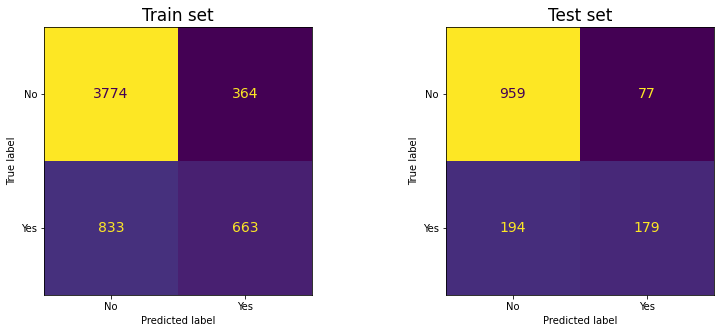

In [13]:
accuracy, recall = apply_model('logistic_regression')

In [14]:
model_accuracy['logistic_regression']['accuracy'] = accuracy
model_accuracy['logistic_regression']['recall'] = recall

model_accuracy

{'logistic_regression': {'accuracy': 0.8077, 'recall': 0.4799},
 'decision_tree': {'accuracy': 0, 'recall': 0},
 'random_forest': {'accuracy': 0, 'recall': 0}}

Surprisingly, the test set had a higher overall accuracy (0.8077). The model is better at predicting the label 'No' (recall = 0.9257), probably because of the inbalencement of the data (there are way more 'No' than 'Yes' labels).

### Decision Tree

Training set
              precision    recall  f1-score   support

          No     0.9904    0.9971    0.9937      4138
         Yes     0.9918    0.9733    0.9825      1496

    accuracy                         0.9908      5634
   macro avg     0.9911    0.9852    0.9881      5634
weighted avg     0.9908    0.9908    0.9907      5634

Test set
              precision    recall  f1-score   support

          No     0.8185    0.8098    0.8142      1036
         Yes     0.4870    0.5013    0.4941       373

    accuracy                         0.7282      1409
   macro avg     0.6528    0.6556    0.6541      1409
weighted avg     0.7308    0.7282    0.7294      1409



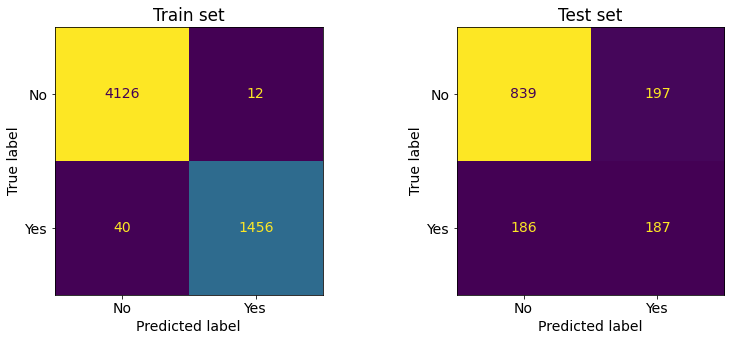

In [15]:
accuracy, recall = apply_model('decision_tree')

Decision trees tend to overfit the training data. The overall performance for the test set is worse than what we achieved with logistic regression.

In [16]:
model_accuracy['decision_tree']['accuracy'] = accuracy
model_accuracy['decision_tree']['recall'] = recall

### Cross-validation on the decision tree

In [17]:
accuracy, accuracy_std = apply_model('cv')

print('Average accuracy of {:.4f} with {:.4f} standard deviation'.format(accuracy, accuracy_std))


Average accuracy of 0.7179 with 0.0126 standard deviation


### Random Forest

Training set
              precision    recall  f1-score   support

          No     0.9947    0.9925    0.9936      4138
         Yes     0.9794    0.9853    0.9823      1496

    accuracy                         0.9906      5634
   macro avg     0.9870    0.9889    0.9880      5634
weighted avg     0.9906    0.9906    0.9906      5634

Test set
              precision    recall  f1-score   support

          No     0.8196    0.8726    0.8453      1036
         Yes     0.5686    0.4665    0.5125       373

    accuracy                         0.7651      1409
   macro avg     0.6941    0.6695    0.6789      1409
weighted avg     0.7531    0.7651    0.7572      1409



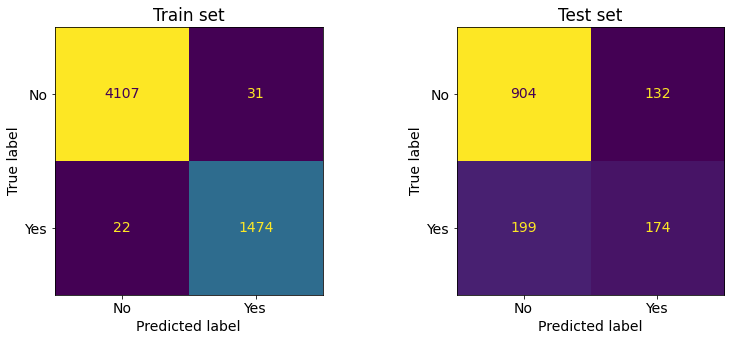

In [18]:
accuracy, recall = apply_model('random_forest')

In [19]:
model_accuracy['random_forest']['accuracy'] = accuracy
model_accuracy['random_forest']['recall'] = recall

In [20]:
inbalanced_model_accuracy = pd.DataFrame.from_dict(model_accuracy, orient='index')
inbalanced_model_accuracy.columns = pd.MultiIndex.from_product([['inbalanced'], inbalanced_model_accuracy.columns])
inbalanced_model_accuracy 

inbalanced        
                      accuracy  recall
logistic_regression     0.8077  0.4799
decision_tree           0.7282  0.5013
random_forest           0.7651  0.4665

## Solve inbalacement

### SMOTE

#### Logistic Regression

Training set
              precision    recall  f1-score   support

          No     0.7278    0.7192    0.7235      4138
         Yes     0.7225    0.7310    0.7267      4138

    accuracy                         0.7251      8276
   macro avg     0.7251    0.7251    0.7251      8276
weighted avg     0.7251    0.7251    0.7251      8276

Test set
              precision    recall  f1-score   support

          No     0.8995    0.7346    0.8087      1036
         Yes     0.5115    0.7721    0.6154       373

    accuracy                         0.7445      1409
   macro avg     0.7055    0.7533    0.7120      1409
weighted avg     0.7968    0.7445    0.7575      1409



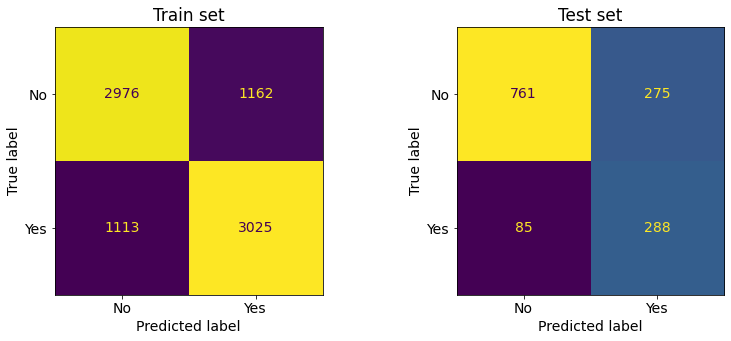

In [21]:
accuracy, recall = apply_model('logistic_regression', imbalecement_strat='smote')

In [22]:
model_accuracy['logistic_regression']['accuracy'] = accuracy
model_accuracy['logistic_regression']['recall'] = recall

#### Decision Tree

Training set
              precision    recall  f1-score   support

          No     0.9909    0.9964    0.9936      4138
         Yes     0.9964    0.9908    0.9936      4138

    accuracy                         0.9936      8276
   macro avg     0.9936    0.9936    0.9936      8276
weighted avg     0.9936    0.9936    0.9936      8276

Test set
              precision    recall  f1-score   support

          No     0.8274    0.7635    0.7942      1036
         Yes     0.4592    0.5576    0.5036       373

    accuracy                         0.7090      1409
   macro avg     0.6433    0.6606    0.6489      1409
weighted avg     0.7299    0.7090    0.7173      1409



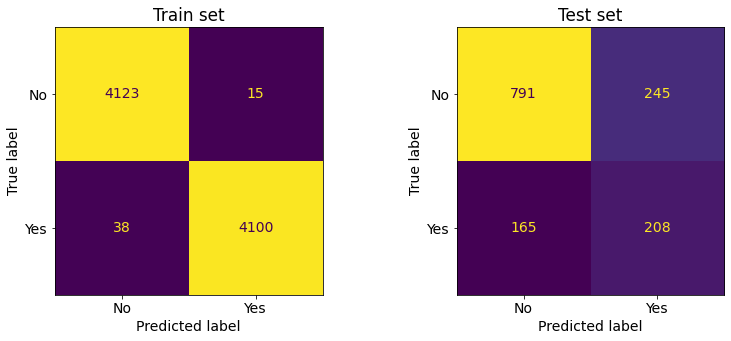

In [23]:
accuracy, recall = apply_model('decision_tree', imbalecement_strat='smote')

In [24]:
model_accuracy['decision_tree']['accuracy'] = accuracy
model_accuracy['decision_tree']['recall'] = recall

#### Random Forest

Training set
              precision    recall  f1-score   support

          No     0.9968    0.9906    0.9937      4138
         Yes     0.9906    0.9969    0.9937      4138

    accuracy                         0.9937      8276
   macro avg     0.9937    0.9937    0.9937      8276
weighted avg     0.9937    0.9937    0.9937      8276

Test set
              precision    recall  f1-score   support

          No     0.8541    0.7857    0.8185      1036
         Yes     0.5132    0.6273    0.5645       373

    accuracy                         0.7438      1409
   macro avg     0.6837    0.7065    0.6915      1409
weighted avg     0.7639    0.7438    0.7513      1409



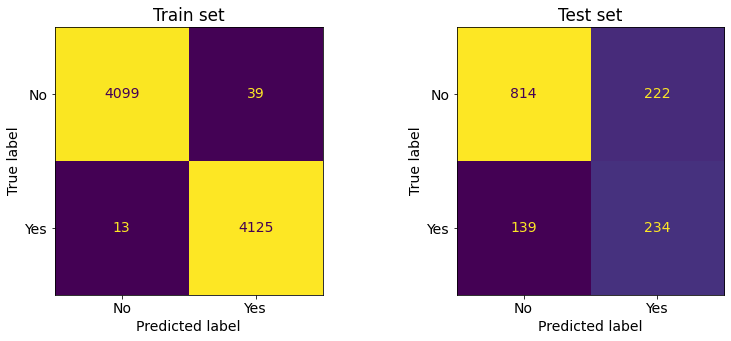

In [25]:
accuracy, recall = apply_model('random_forest', imbalecement_strat='smote')

In [26]:
model_accuracy['random_forest']['accuracy'] = accuracy
model_accuracy['random_forest']['recall'] = recall

In [27]:
smote_model_accuracy = pd.DataFrame.from_dict(model_accuracy, orient='index')
smote_model_accuracy.columns = pd.MultiIndex.from_product([['smote'], smote_model_accuracy.columns])
smote_model_accuracy

smote        
                    accuracy  recall
logistic_regression   0.7445  0.7721
decision_tree         0.7090  0.5576
random_forest         0.7438  0.6273

### TomekLinks

#### Logistic Regression

Training set
              precision    recall  f1-score   support

          No     0.8217    0.8970    0.8577      3710
         Yes     0.6696    0.5174    0.5837      1496

    accuracy                         0.7879      5206
   macro avg     0.7456    0.7072    0.7207      5206
weighted avg     0.7780    0.7879    0.7790      5206

Test set
              precision    recall  f1-score   support

          No     0.8439    0.8764    0.8598      1036
         Yes     0.6156    0.5496    0.5807       373

    accuracy                         0.7899      1409
   macro avg     0.7297    0.7130    0.7203      1409
weighted avg     0.7834    0.7899    0.7860      1409



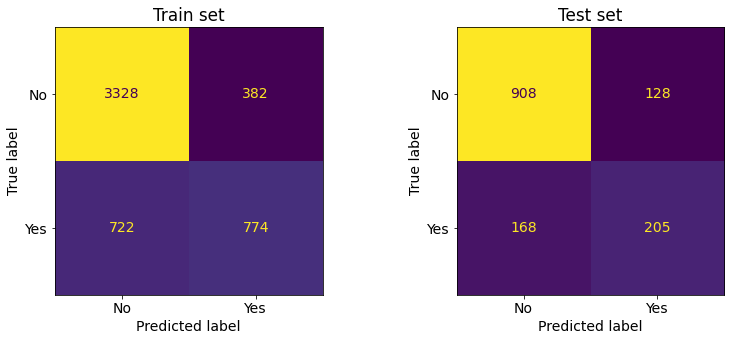

In [28]:
accuracy, recall = apply_model('logistic_regression', imbalecement_strat='tomeklinks')

In [29]:
model_accuracy['logistic_regression']['accuracy'] = accuracy
model_accuracy['logistic_regression']['recall'] = recall

#### Decision Tree

Training set
              precision    recall  f1-score   support

          No     0.9893    0.9968    0.9930      3710
         Yes     0.9918    0.9733    0.9825      1496

    accuracy                         0.9900      5206
   macro avg     0.9906    0.9850    0.9877      5206
weighted avg     0.9900    0.9900    0.9900      5206

Test set
              precision    recall  f1-score   support

          No     0.8296    0.7799    0.8040      1036
         Yes     0.4759    0.5550    0.5124       373

    accuracy                         0.7204      1409
   macro avg     0.6527    0.6674    0.6582      1409
weighted avg     0.7359    0.7204    0.7268      1409



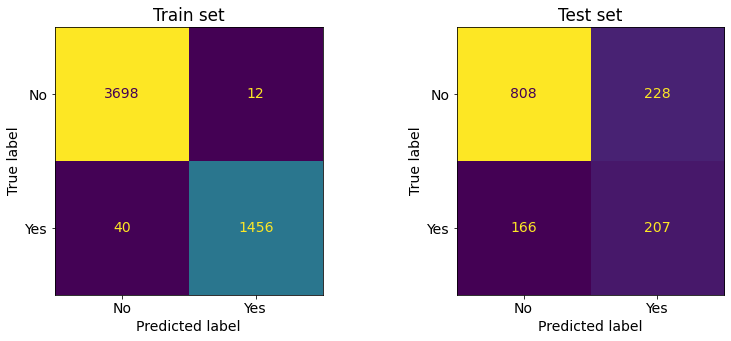

In [30]:
accuracy, recall = apply_model('decision_tree', imbalecement_strat='tomeklinks')

In [31]:
model_accuracy['decision_tree']['accuracy'] = accuracy
model_accuracy['decision_tree']['recall'] = recall

 #### Random Forest

Training set
              precision    recall  f1-score   support

          No     0.9946    0.9914    0.9930      3710
         Yes     0.9788    0.9866    0.9827      1496

    accuracy                         0.9900      5206
   macro avg     0.9867    0.9890    0.9878      5206
weighted avg     0.9900    0.9900    0.9900      5206

Test set
              precision    recall  f1-score   support

          No     0.8452    0.8272    0.8361      1036
         Yes     0.5468    0.5791    0.5625       373

    accuracy                         0.7615      1409
   macro avg     0.6960    0.7032    0.6993      1409
weighted avg     0.7662    0.7615    0.7637      1409



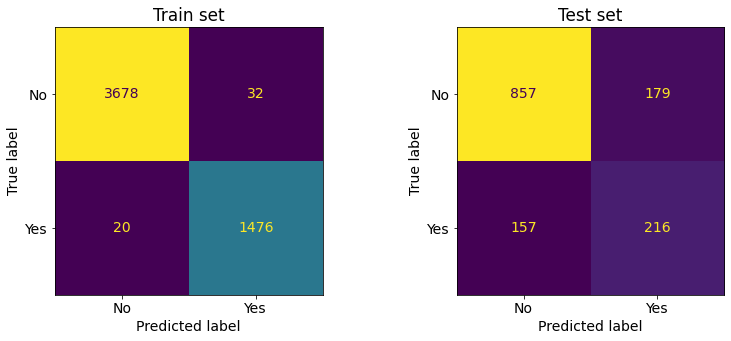

In [32]:
accuracy, recall = apply_model('random_forest', imbalecement_strat='tomeklinks')

In [33]:
model_accuracy['random_forest']['accuracy'] = accuracy
model_accuracy['random_forest']['recall'] = recall

In [34]:
tl_model_accuracy = pd.DataFrame.from_dict(model_accuracy, orient='index')
tl_model_accuracy.columns = pd.MultiIndex.from_product([['tomek_links'], tl_model_accuracy.columns])
tl_model_accuracy

tomek_links        
                       accuracy  recall
logistic_regression      0.7899  0.5496
decision_tree            0.7204  0.5550
random_forest            0.7615  0.5791

## Summary

In [35]:
summary = pd.concat([
    inbalanced_model_accuracy,
    smote_model_accuracy,
    tl_model_accuracy
], axis=1)
summary

inbalanced            smote         tomek_links        
                      accuracy  recall accuracy  recall    accuracy  recall
logistic_regression     0.8077  0.4799   0.7445  0.7721      0.7899  0.5496
decision_tree           0.7282  0.5013   0.7090  0.5576      0.7204  0.5550
random_forest           0.7651  0.4665   0.7438  0.6273      0.7615  0.5791

* _Logistic Regression_ had the best overall performance;
* Applying under- or oversampling methods didn't improve most of the models;
* _SMOTE_ was the best method to improve the recall metric (true positives) when combined with _logistic regression_.